<a href="https://colab.research.google.com/github/HenryJi529/ColabNotebooks/blob/main/PracticePyG0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyG基础使用

In [121]:
import torch
torch.version.cuda

'11.8'

In [122]:
# %%capture
!pip install SciencePlots
!pip install powerlaw
!pip install torchmetrics
!pip install torchinfo
!pip install -U mlxtend
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

from IPython.display import clear_output
clear_output()

In [123]:
import matplotlib as mpl
from matplotlib import pyplot as plt
# 'serif', 'sans-serif', 'monospace', 'fantasy', 'cursive'
cnFont = {'fontname':'Songti SC', 'color':'darkred', 'weight':'bold', 'size': 30}
# plt.rcParams['figure.dpi'] = 400
# plt.rcParams['savefig.bbox'] = 'tight'
import seaborn as sns
import scienceplots


import numpy as np
np.random.seed(520)
from scipy import stats, optimize
import pandas as pd
from pandas import Series,DataFrame
# pd.set_option('display.max_columns',100)
# pd.set_option('display.max_rows',100)

import networkx as nx
import powerlaw


from typing import Tuple, Dict, List
import os
import time, datetime
import random
from pathlib import Path
import requests, zipfile
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torchinfo import summary
from PIL import Image
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import torch_geometric
from torch_geometric import datasets, transforms
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, Linear

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

## 了解数据

In [124]:
dataset = datasets.KarateClub()
data = dataset[0]
print(f"num of nodes: {dataset[0].num_nodes}")
data

num of nodes: 34


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [125]:
data.x.sum().item()

34.0

In [126]:
DataFrame(data.edge_index.T, columns=["source", "target"]).head()

,source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [127]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

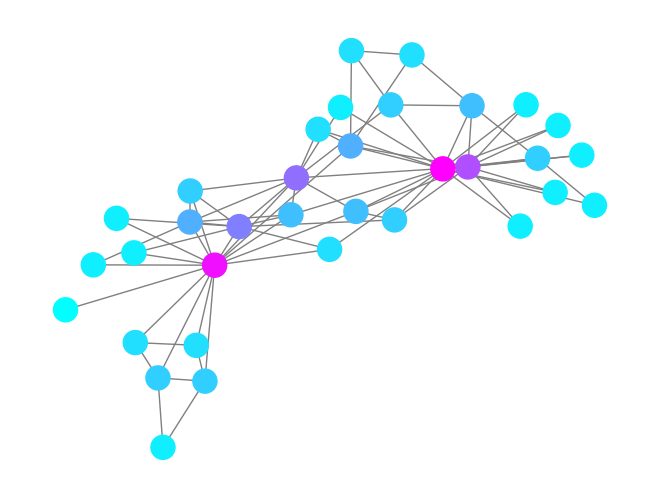

In [128]:
G = to_networkx(data, to_undirected=True)
nodeSize = [G.degree(i)*100 for i in G.nodes()]
node_colors = [G.degree(i) for i in G.nodes()]
options = {
    'pos': nx.spring_layout(G),
    # 'node_size': nodeSize,
    'node_color': node_colors,
    'cmap': plt.cm.cool, # 设置节点colormap
    'edge_color': "gray",
    # 'with_labels': True,
}
nx.draw(G, **options)
plt.show()

## 定义模型

In [129]:
class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(dataset.num_features, 4)
    self.conv2 = GCNConv(4, 4)
    self.conv3 = GCNConv(4, 2)
    self.classifier = Linear(2, dataset.num_classes)

  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    h = h.tanh()
    h = self.conv3(h, edge_index)
    prediction_vector = h.tanh()

    logits = self.classifier(prediction_vector)

    return logits, prediction_vector

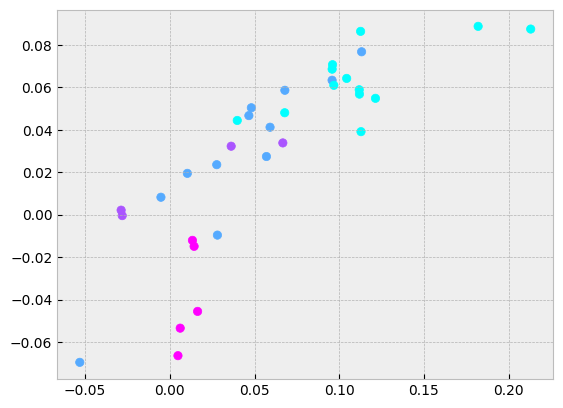

In [130]:
model = GCN()
model.eval()
with torch.inference_mode():
  logits, prediction_vector = model(data.x, data.edge_index)
  with plt.style.context('bmh'):
    plt.scatter(prediction_vector[:,0], prediction_vector[:,1], c=data.y, cmap=plt.cm.cool)

In [131]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

def train_step(model: torch.nn.Module, data):
  model.train()
  y_pred_logits, prediction_vector = model(data.x, data.edge_index)
  loss = loss_fn(y_pred_logits[data.train_mask], data.y[data.train_mask])
  y_pred_prob = torch.softmax(y_pred_logits, dim=1)
  y_pred_label = y_pred_prob.argmax(dim=1)
  acc = (y_pred_label[data.train_mask]==data.y[data.train_mask]).sum()/len(data.y[data.train_mask])
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item(), prediction_vector, acc.item()

results = {"train_loss": [], 
           "prediction_vector": [],
           "train_acc": []}

model = model.to(DEVICE)
data = data.to(DEVICE)


start_time = time.time()

epochs = 400

for epoch in tqdm(range(epochs)):
  train_loss, prediction_vector, train_acc = train_step(model, data)
  results["train_loss"].append(train_loss)
  results["prediction_vector"].append(prediction_vector)
  results["train_acc"].append(train_acc)

end_time = time.time()
during_seconds = int(end_time - start_time)

print(f"运行时间: {datetime.timedelta(seconds=during_seconds)}")

  0%|          | 0/400 [00:00<?, ?it/s]

运行时间: 0:00:01


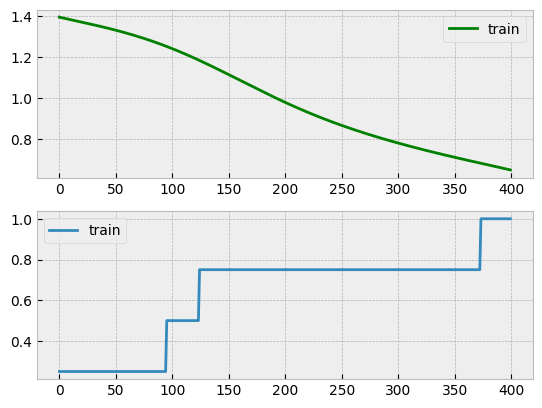

In [132]:
with plt.style.context('bmh'):
  fig, axes = plt.subplots(2,1)
  epochs = len(results['train_loss'])
  axes[0].plot(range(epochs), results["train_loss"], label="train", color="green")
  # axes[0].plot(range(epochs), results["test_loss"], label="test", color="brown")
  axes[0].legend()
  axes[1].plot(range(epochs), results["train_acc"], label="train")
  # axes[1].plot(range(epochs), results["test_accs"], label="test")
  axes[1].legend()

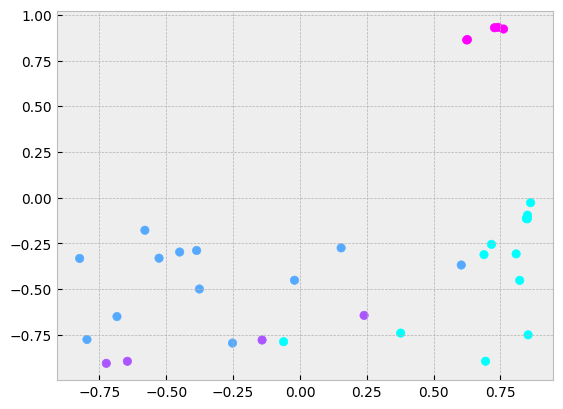

In [133]:
with plt.style.context('bmh'):
    prediction_vector = prediction_vector.detach().cpu()
    plt.scatter(prediction_vector[:,0], prediction_vector[:,1], c=data.y.cpu(), cmap=plt.cm.cool)